In [1]:
import os

import matplotlib.pyplot as plt
import pandas as pd
import torch

from data.config import (
    MODELS_DIR, 
    DATA_ADAPTATION_DIR, 
    TRANSFORM_MODE, 
    TRAIN_VALID_SPLIT, 
    SEED, 
    IMG_GRADIENT, 
    IMG_MODE
)
from dataset import CoarseMaskDataset, SimpleCoarseMaskDataset
from u_net import Coarse2FineTiny
from u_net_res_attention import Coarse2FineUNetAttention
from u_net_residual import Coarse2FineTinyRes
from torch.utils.data import random_split
import numpy as np

In [2]:
models = os.listdir(MODELS_DIR)

model_dirs = ['unetres16-32_bce-dice_18052025', 'unetres16-32_bce-dice_18052025', 
               'u_net_16_128_bce_dice', 'u_net_res_16_128_bce_dice',
               'unet16-128_bce-dice-bound_19052025', 'unetres16-128_bce-dice-bound_19052025',
               'unetres32-256_bce-dice-bound_21052025', "attention_32-256_bce-dice-bound_27052025"]

model_classes = [Coarse2FineTiny, Coarse2FineTinyRes,
                 Coarse2FineTiny, Coarse2FineTinyRes,
                 Coarse2FineTiny, Coarse2FineTinyRes,
                 Coarse2FineTinyRes, Coarse2FineUNetAttention]

model_names = ['U-Net 16-32 BCE-Dice',
               'U-Net Res 16-32 BCE-Dice',
               'U-Net 16-128 BCE-Dice',
               'U-Net Res 16-128 BCE-Dice',
               'U-Net 16-128 BCE-Dice+Bound',
               'U-Net Res 16-128 BCE-Dice+Bound',
               'U-Net Res 32-256 BCE-Dice+Bound',
               "U-Net Res (Attention) 32-256 BCE-Dice+Bound"]

losses = [["bce", "dice"],
         ["bce", "dice"],
         ["bce", "dice"],
         ["bce", "dice"],
         ["bce", "dice", "boundary"],
         ["bce", "dice", "boundary"],
         ["bce", "dice", "boundary"],
         ["bce", "dice", "boundary"]]

features = [[16, 32], 
            [16, 32],
            [16, 32, 64, 128],
            [16, 32, 64, 128],
            [16, 32, 64, 128],
            [16, 32, 64, 128],
            [32, 64, 128, 256],
            [32, 64, 128, 256]] 

In [3]:
def plot_result(dataset, model, num_samples=5, threshold=0.5, common_title="Model Predictions", column_titles=None, idx_img=None, save_images=False):
    """
    Plots a grid of model predictions with a common title and column-specific titles.

    Args:
        dataset: PyTorch dataset returning (input, target) tuples.
        model: Trained PyTorch model.
        num_samples (int): Number of samples (rows) to show.
        threshold (float): Threshold for binary mask prediction.
        common_title (str): Title for the whole figure.
        column_titles (list[str]): Titles for each column (4 expected).
    """
    if idx_img is None:
        idx_img = 89

    n_rows = min(num_samples, len(dataset))
    n_cols = 4  # input image, input mask, target mask, predicted mask

    if column_titles is None:
        column_titles = [
            "Input coarse mask",
            "Input image",
            "Ground truth mask",
            "Predicted mask",
        ]

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * 2, n_rows * 3))
    fig.suptitle(common_title, fontsize=16)

    device = next(model.parameters()).device  # get model's device

    for i in range(n_rows):
        item, target = dataset[i + idx_img]  # FIXME: index offset still manual
        item = item.to(device)

        with torch.no_grad():
            predicted = model(item.unsqueeze(0))
            predicted_probs = torch.sigmoid(predicted)
            predicted_mask = (predicted_probs > threshold).float()

        images = [
            item[0].cpu(),          # input coarse mask
            item[1].cpu(),          # input image
            target[0].cpu(),        # ground truth mask
            predicted_mask[0][0].cpu(),  # predicted mask
        ]

        if save_images:
            np.save(os.path.join("..\..\COCO_dset_adaptation\plot_dset\gt", f"ground_truth_mask_{i}.npy"), images[2].numpy())

        for j in range(n_cols):
            ax = axes[i, j] if n_rows > 1 else axes[j]
            ax.imshow(images[j], cmap="gray")
            ax.axis("off")
            if i == 0:
                ax.set_title(column_titles[j], fontsize=12)

    plt.tight_layout(rect=[0, 0, 1, 1])  # leave space for suptitle
    plt.show()


def evaluate_checkpoint(ckpt_dir: str) -> None:
    metrics_csv: str = os.path.join(ckpt_dir, "metrics.csv")
    df: pd.DataFrame = pd.read_csv(metrics_csv)

    train_df = df[df["train_loss"].notnull()]
    val_df = df[df["val_loss"].notnull()]

    # plot train and valid loss
    plt.figure(figsize=(10, 6))
    plt.plot(train_df["step"], train_df["train_loss"], label="Train Loss", marker="o")
    plt.plot(val_df["step"], val_df["val_loss"], label="Validation Loss", marker="s")
    plt.xlabel("Step")
    plt.ylabel("Loss")
    # plt.yscale("log")
    plt.title("Train and Validation Loss over Steps")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # plot valid iou
    plt.plot(val_df["step"], val_df["val_iou"])
    plt.xlabel("Step")
    plt.ylabel("Validation Intersection over Union")
    plt.show()

    # TODO plot other metrics if present

In [4]:
def plot_result_fixed(dataset, model, num_samples=None, threshold=0.5, common_title="Model Predictions", column_titles=None):
    """
    Plots a grid of model predictions with a common title and column-specific titles.

    Args:
        dataset: PyTorch dataset returning (input, target) tuples.
        model: Trained PyTorch model.
        num_samples (int): Number of samples (rows) to show.
        threshold (float): Threshold for binary mask prediction.
        common_title (str): Title for the whole figure.
        column_titles (list[str]): Titles for each column (4 expected).
    """
    if num_samples is None:
        num_samples = len(dataset)

    n_rows = min(num_samples, len(dataset))
    n_cols = 4  # input image, input mask, target mask, predicted mask

    if column_titles is None:
        column_titles = [
            "Input coarse mask",
            "Input image",
            "Ground truth mask",
            "Predicted mask",
        ]

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * 2, n_rows * 3))
    fig.suptitle(common_title, fontsize=16)

    device = next(model.parameters()).device  # get model's device

    for i in range(n_rows):
        item, target = dataset[i]
        item = item.to(device)

        with torch.no_grad():
            predicted = model(item.unsqueeze(0))
            predicted_probs = torch.sigmoid(predicted)
            predicted_mask = (predicted_probs > threshold).float()

        images = [
            item[0].cpu(),          # input coarse mask
            item[1].cpu(),          # input image
            target[0].cpu(),        # ground truth mask
            predicted_mask[0][0].cpu(),  # predicted mask
        ]

        for j in range(n_cols):
            ax = axes[i, j] if n_rows > 1 else axes[j]
            ax.imshow(images[j], cmap="gray")
            ax.axis("off")
            if i == 0:
                ax.set_title(column_titles[j], fontsize=12)

    plt.tight_layout(rect=[0, 0, 1, 1])  # leave space for suptitle
    plt.show()


def evaluate_checkpoint(ckpt_dir: str) -> None:
    metrics_csv: str = os.path.join(ckpt_dir, "metrics.csv")
    df: pd.DataFrame = pd.read_csv(metrics_csv)

    train_df = df[df["train_loss"].notnull()]
    val_df = df[df["val_loss"].notnull()]

    # plot train and valid loss
    plt.figure(figsize=(10, 6))
    plt.plot(train_df["step"], train_df["train_loss"], label="Train Loss", marker="o")
    plt.plot(val_df["step"], val_df["val_loss"], label="Validation Loss", marker="s")
    plt.xlabel("Step")
    plt.ylabel("Loss")
    # plt.yscale("log")
    plt.title("Train and Validation Loss over Steps")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # plot valid iou
    plt.plot(val_df["step"], val_df["val_iou"])
    plt.xlabel("Step")
    plt.ylabel("Validation Intersection over Union")
    plt.show()

    # TODO plot other metrics if present

In [5]:
full_dataset = CoarseMaskDataset(
        DATA_ADAPTATION_DIR,
        transform_type=TRANSFORM_MODE,
        image_gradient=IMG_GRADIENT,
        mode=IMG_MODE,
    )

total_len = len(full_dataset)
val_len = int(total_len * TRAIN_VALID_SPLIT)
train_len = total_len - val_len
train_dataset, val_dataset = random_split(
    full_dataset,
    [train_len, val_len],
    generator=torch.Generator().manual_seed(SEED),
)

fixed_mask_dataset = SimpleCoarseMaskDataset(
    r"..\..\COCO_dset_adaptation\plot_dset",
    image_gradient=IMG_GRADIENT,
    mode=IMG_MODE,
)

loading annotations into memory...
Done (t=0.17s)
creating index...
index created!


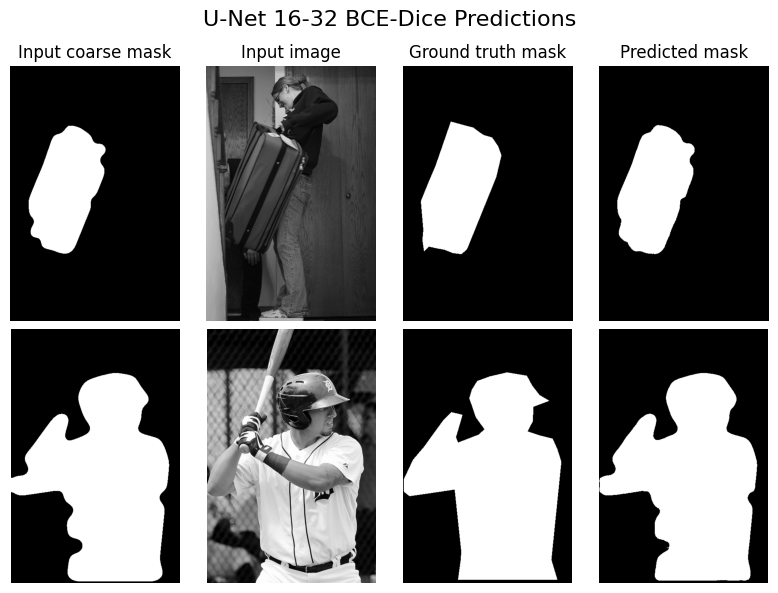

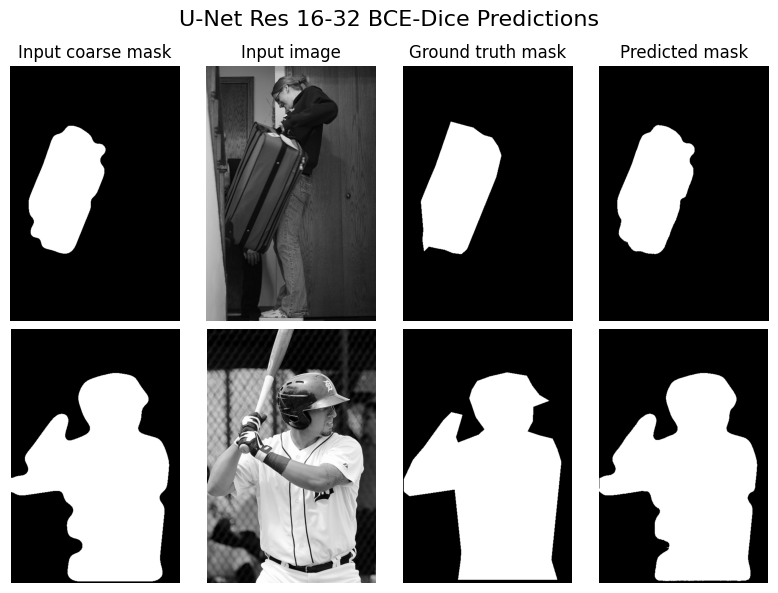

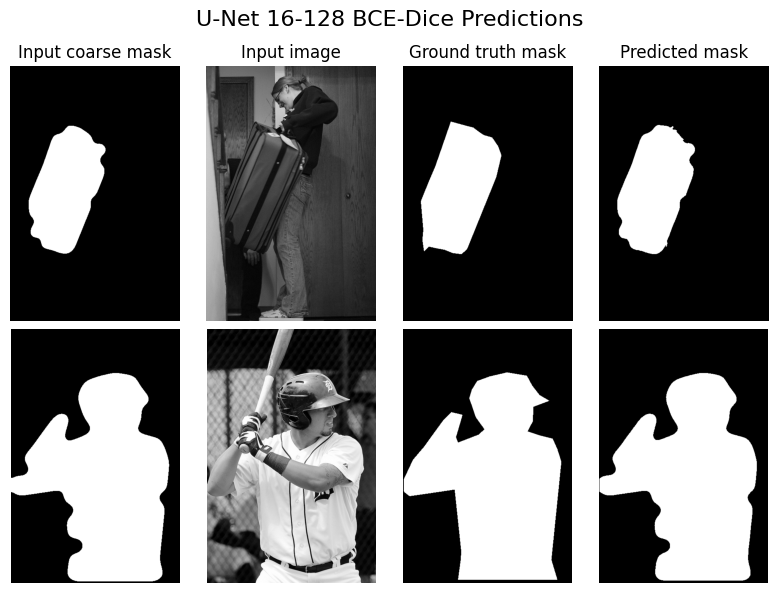

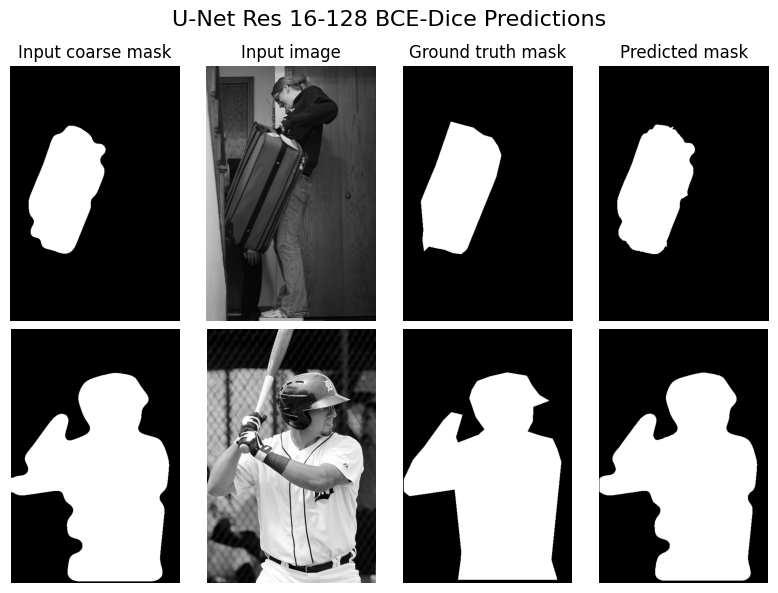

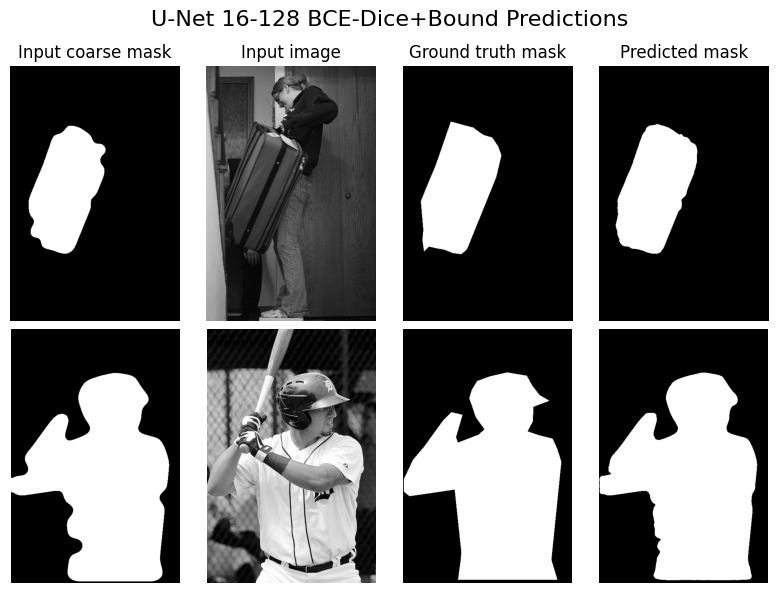

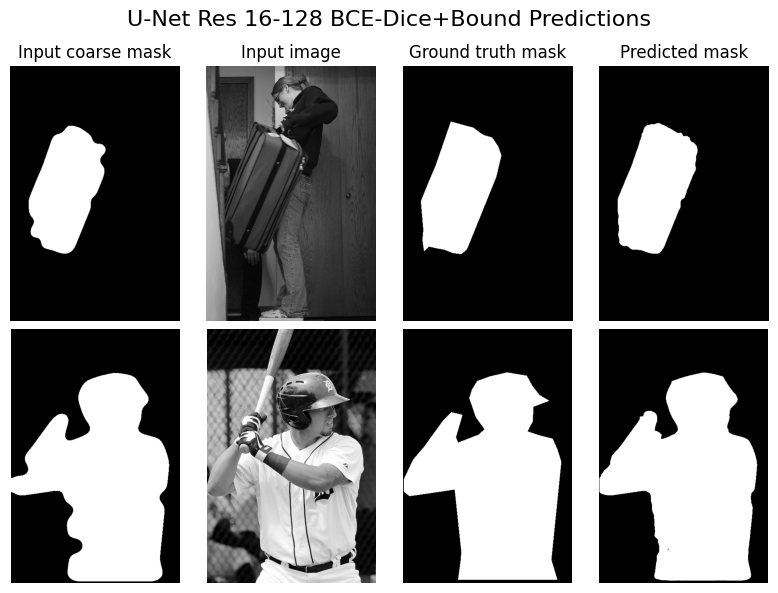

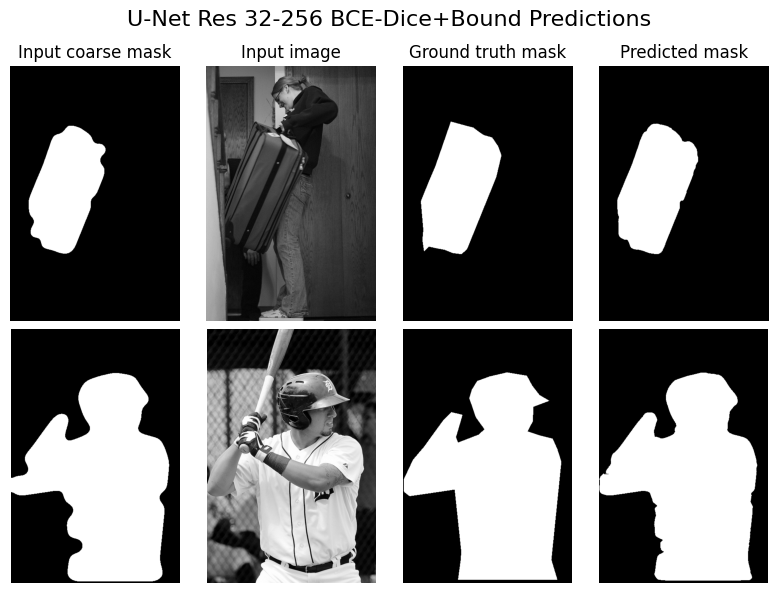

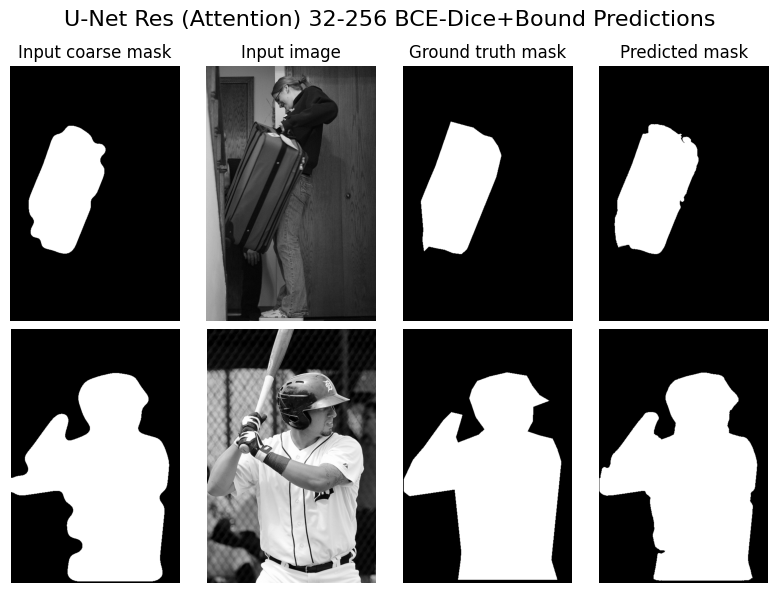

In [6]:
for model_dir, model_class, model_name, loss, feat in zip(model_dirs, model_classes, model_names, losses, features):

    model_path = MODELS_DIR / model_dir / "checkpoints" / "best-checkpoint.ckpt"

    model = model_class.load_from_checkpoint(
        model_path,
        losses=loss,
        features=feat,
        loss_weights=[.4, .4, .2] if len(loss) == 3 else [.5, .5]
    )

    plot_result_fixed(fixed_mask_dataset, model, common_title=f"{model_name} Predictions", threshold=0.4)
    #evaluate_checkpoint(os.path.join(models_dir, model_dir))

In [9]:
import os
import pandas as pd

# Define the base path
base_path = "..\\..\\saved_models"

# List to hold all data rows
results = []

# Walk through all subdirectories
for folder_name in os.listdir(base_path):
    folder_path = os.path.join(base_path, folder_name)
    if not os.path.isdir(folder_path):
        continue

    metrics_path = os.path.join(folder_path, "metrics.csv")
    checkpoint_path = os.path.join(folder_path, "checkpoints", "best-checkpoint.ckpt")

    if os.path.exists(metrics_path) and os.path.exists(checkpoint_path):
        # Load metrics CSV
        df = pd.read_csv(metrics_path)

        # Find the row with the minimum val_loss
        min_row = df.loc[df["val_loss"].idxmin()]

        # Get file size in MB
        size_mb = os.path.getsize(checkpoint_path) / (1024 * 1024)

        # Format all values to 3 decimal places
        format_value = lambda x: f"{x:.3f}" if pd.notna(x) else None

        # Append relevant info
        results.append({
            "Model Name": folder_name,
            "Size (MB)": size_mb,
            "val_accuracy": min_row.get("val_accuracy", None),
            "val_boundary_iou": min_row.get("val_boundary_iou", None),
            "val_hausdorff": min_row.get("val_hausdorff", None),
            "val_iou": min_row.get("val_iou", None),
            "val_loss": min_row.get("val_loss", None),
        })

# Create DataFrame
output_df = pd.DataFrame(results)

# Round and format all float values to 3 decimals
for col in output_df.columns[1:]:
    output_df[col] = output_df[col].map(lambda x: f"{x:.4f}" if pd.notna(x) else "")

# Sort by model size
output_df["Size (MB)_float"] = output_df["Size (MB)"].astype(float)
output_df = output_df.sort_values(by="Size (MB)_float")
output_df = output_df.drop(columns=["Size (MB)_float"])

# Save to CSV with comma separator and dot as decimal
output_csv_path = os.path.join(base_path, "summary_metrics.csv")
output_df.to_csv(output_csv_path, index=False, sep=",")
print(f"Saved summary to {output_csv_path}")


Saved summary to ..\..\saved_models\summary_metrics.csv


In [4]:
import os
from PIL import Image
import pandas as pd

# Set your folder path (edit this)
image_dir = r"..\..\COCO_dset_adaptation\reduced_dset_1000\train2014"  # 🔁 Set correct path here

# Collect image statistics
data = []

for file_name in os.listdir(image_dir):
    if file_name.lower().endswith(".jpg"):
        image_path = os.path.join(image_dir, file_name)
        try:
            with Image.open(image_path) as img:
                width, height = img.size
                total_pixels = width * height
                data.append({
                    "width": width,
                    "height": height,
                    "total_pixels": total_pixels
                })
        except Exception as e:
            print(f"Could not open {file_name}: {e}")

print("Images found:", len(data))

# Only continue if images were processed
if data:
    df = pd.DataFrame(data)
    summary = pd.DataFrame({
        "width": [df["width"].min(), df["width"].max(), df["width"].mean(), df["width"].median()],
        "height": [df["height"].min(), df["height"].max(), df["height"].mean(), df["height"].median()],
        "total_pixels": [df["total_pixels"].min(), df["total_pixels"].max(), df["total_pixels"].mean(), df["total_pixels"].median()],
    }, index=["Min", "Max", "Mean", "Median"])
    
    print("\nSummary:")
    print(summary.round(2))
else:
    print("⚠️ No .png images found in the directory.")


Images found: 1000

Summary:
         width  height  total_pixels
Min     210.00  168.00       35280.0
Max     640.00  640.00      409600.0
Mean    579.44  487.74      278641.3
Median  640.00  480.00      273920.0


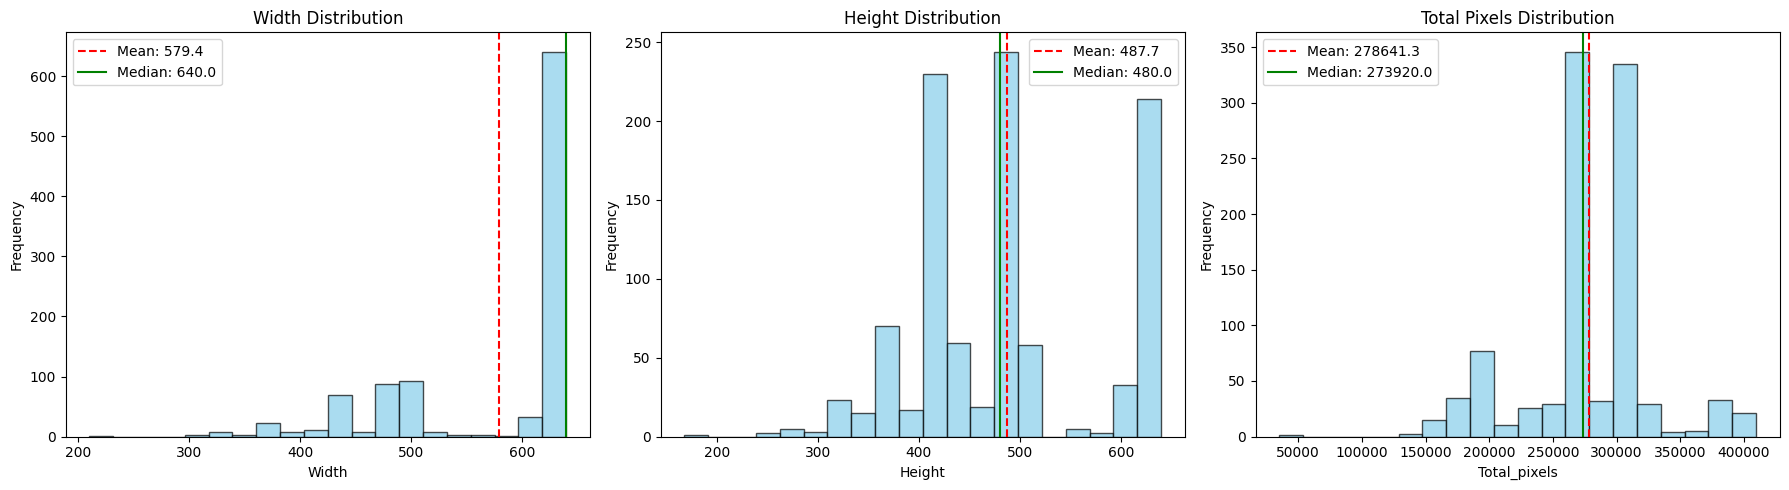

In [5]:
import matplotlib.pyplot as plt

# Set up the figure with 3 subplots
fig, axs = plt.subplots(1, 3, figsize=(18, 5))

# Plot settings
fields = ["width", "height", "total_pixels"]
titles = ["Width Distribution", "Height Distribution", "Total Pixels Distribution"]

for ax, field, title in zip(axs, fields, titles):
    ax.hist(df[field], bins=20, color="skyblue", edgecolor="black", alpha=0.7)
    ax.axvline(df[field].mean(), color="red", linestyle="--", label=f"Mean: {df[field].mean():.1f}")
    ax.axvline(df[field].median(), color="green", linestyle="-", label=f"Median: {df[field].median():.1f}")
    ax.set_title(title)
    ax.set_xlabel(field.capitalize())
    ax.set_ylabel("Frequency")
    ax.legend()

plt.tight_layout()
plt.show()
